# IAU - Inteligentná analýza údajov (2024/2025)

#### Autori: Jan Lenhart (50 %), Marek Čederle (50 %)
##### Cvičenie: Pondelok 15:00, Cvičiaci: Ing. Oleksandr Lytvyn

<font color='salmon'>
    <b>Upozornenie:</b>
    Niektoré bloky kódu trvajú dlhú dobu ak ide o trénovanie modelov a podobne. (runtime celeho dokumentu ~30 min)
</font>

## Fáza 3 - Strojové učenie

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statistics import LinearRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, IsolationForest
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, f_classif, chi2, RFE, VarianceThreshold, SelectFromModel, mutual_info_regression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.linear_model import LogisticRegression


Na začiatok sme si importovali predspracované dáta z druhej fázy, s ktorými sme ďalej pracovali.

In [2]:
train = pd.read_csv('preprocessed_train.csv', delimiter=',')
test  = pd.read_csv('preprocessed_test.csv', delimiter=',')

In [3]:
X_train, X_test, y_train, y_test = train.drop(columns=['mwra']), test.drop(columns=['mwra']), train['mwra'], test['mwra']

In [4]:
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

### 3.1 Jednoduchý klasifikátor na základe závislosti v dátach

#### 3.1.A Naimplementujte jednoduchý ID3 klasifikátor s hĺbkou min 2 (vrátane root/koreň).

```py
class CustomClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        return self

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        return np.zeros(X.shape[0])

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)
```

Nasledujúci kód, predstavujúci vlastný ID3 klasifikátor sme implementovali z vyššie uvedeného kódu, ktorý bol generovaný pomocou ChatGPT. Daný kód predstavuje šablónu pre implementáciu vlastného klasifikátora knižnice `sklearn`.

In [5]:
# following code is co-engineered with ChatGPT
class ID3Classifier(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.tree_ = None

    def _entropy(self, y):
        counts = np.bincount(y)
        probabilities = counts / len(y)
        return -np.sum([p * np.log2(p) for p in probabilities if p > 0])

    def _information_gain(self, X, y, feature):
        total_entropy = self._entropy(y)
        values, counts = np.unique(X[:, feature], return_counts=True)
        weighted_entropy = sum(
            (counts[i] / sum(counts)) * self._entropy(y[X[:, feature] == values[i]])
            for i in range(len(values))
        )
        return total_entropy - weighted_entropy
    
    def _get_optimal_threshold(self, X, y, feature):
        values = np.unique(X[:, feature])
        best_threshold = None
        best_info_gain = -float('inf')
        for value in values:
            left_mask = X[:, feature] < value
            right_mask = ~left_mask
            left_y = y[left_mask]
            right_y = y[right_mask]
            
            left_entropy = self._entropy(left_y)
            right_entropy = self._entropy(right_y)
            
            weighted_entropy = (len(left_y) / len(y)) * left_entropy + (len(right_y) / len(y)) * right_entropy
            info_gain = self._entropy(y) - weighted_entropy
            
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_threshold = value

        return best_threshold

    def _id3(self, X, y, features):
        if len(np.unique(y)) == 1:
            return {'value': np.unique(y)[0]}
        if len(features) == 0:
            return {'value': np.bincount(y).argmax()}
        best_feature = max(features, key=lambda f: self._information_gain(X, y, f))
        best_threshold = self._get_optimal_threshold(X, y, best_feature)
        tree = {'feature': best_feature, 'threshold': best_threshold, 'left': None, 'right': None}
        left_mask = X[:, best_feature] < best_threshold
        right_mask = ~left_mask
        left_X, left_y = X[left_mask], y[left_mask]
        right_X, right_y = X[right_mask], y[right_mask]
        tree['left'] = self._id3(left_X, left_y, [f for f in features if f != best_feature])
        tree['right'] = self._id3(right_X, right_y, [f for f in features if f != best_feature])
        return tree

    def fit(self, X, y):
        y = y.astype(int)
        X, y = check_X_y(X, y)
        self.tree_ = self._id3(X, y, range(X.shape[1]))
        return self
    
    def _predict_instance(self, instance, tree):
        if 'value' in tree:
            return tree['value']
        feature_value = instance[tree['feature']]
        if feature_value <= tree['threshold']:
            return self._predict_instance(instance, tree['left'])
        return self._predict_instance(instance, tree['right'])

    def predict(self, X):
        check_is_fitted(self, "tree_")
        X = check_array(X)
        return np.array([self._predict_instance(row, self.tree_) for row in X])

    # def score(self, X, y):
    #     y_pred = self.predict(X)
    #     return np.mean(y_pred == y)

Opis funkcií vlastného ID3 klasifikátora:

- `_entropy()`: Vypočíta entropiu podľa štandardného vzorca.

- `_information_gain()`: Vypočíta information gain podľa štandardného vzorca.

- `_get_optimal_threshold()`: Vypočíta optimálny threshold pre daný atribút (feature) na základe entropie a information gain.

- `_id3()`: Zo vstupných dát vytvorí ID3 rozhodovací strom, ktorý sa trénuje.

- `fit()`: Spústí trénovanie modelu.

- `_predict_instance()`: Predikuje výsledok jednej inštancie resp. jedného riadoku dát.

- `predict()`: Predikuje výsledné hodnoty na základe natrénovaného modelu a vstupených dát.

<!-- - `score()`: Vypočíta skóre resp. presnosť (accuracy) modelu. -->



In [6]:
# avg runtime ~1 min
id3_classifier = ID3Classifier()
id3_classifier.fit(X_train, y_train)

ID3Classifier()

**Jednoduchá CLI Style vizualizácia nášho ID3 rozhodovacieho stromu**

In [7]:
def id3_print_recursive(tree, X, y, depth = 0, left = False, right = False):
    for i in range(depth):
        print(end='  ')
    if (left):
        print('l-', end='')
    if (right):
        print('r-', end='')
    if ('feature' in tree):
        print(f"feature: {X.columns[tree['feature']]}, threshold: {tree['threshold']}")
        if (tree['left']):
            id3_print_recursive(tree['left'], X, y, depth + 1, left=True)
        if (tree['right']):
            id3_print_recursive(tree['right'], X, y, depth + 1, right=True)
    else:
        print(f"value: {tree['value']}")

In [8]:
print(id3_classifier.tree_)

{'feature': 4, 'threshold': np.float64(0.4779091140690208), 'left': {'feature': 2, 'threshold': np.float64(0.7328192076652095), 'left': {'feature': 0, 'threshold': np.float64(0.7041603942984769), 'left': {'feature': 1, 'threshold': np.float64(0.4040360843939481), 'left': {'feature': 3, 'threshold': np.float64(-0.7916507198728443), 'left': {'value': np.int64(0)}, 'right': {'value': np.int64(1)}}, 'right': {'feature': 3, 'threshold': np.float64(-1.149980668731062), 'left': {'value': np.int64(0)}, 'right': {'value': np.int64(1)}}}, 'right': {'feature': 1, 'threshold': np.float64(0.5942634655102699), 'left': {'feature': 3, 'threshold': np.float64(0.3507663421681893), 'left': {'value': np.int64(0)}, 'right': {'value': np.int64(1)}}, 'right': {'feature': 3, 'threshold': np.float64(-0.3964413214102481), 'left': {'value': np.int64(0)}, 'right': {'value': np.int64(1)}}}}, 'right': {'feature': 1, 'threshold': np.float64(-0.2472172295606615), 'left': {'feature': 0, 'threshold': np.float64(0.31100

In [9]:
id3_print_recursive(id3_classifier.tree_, X_train, y_train)

feature: p.android.packageinstaller, threshold: 0.4779091140690208
  l-feature: p.android.chrome, threshold: 0.7328192076652095
    l-feature: c.dogalize, threshold: 0.7041603942984769
      l-feature: p.system, threshold: 0.4040360843939481
        l-feature: p.android.gm, threshold: -0.7916507198728443
          l-value: 0
          r-value: 1
        r-feature: p.android.gm, threshold: -1.149980668731062
          l-value: 0
          r-value: 1
      r-feature: p.system, threshold: 0.5942634655102699
        l-feature: p.android.gm, threshold: 0.3507663421681893
          l-value: 0
          r-value: 1
        r-feature: p.android.gm, threshold: -0.3964413214102481
          l-value: 0
          r-value: 1
    r-feature: p.system, threshold: -0.2472172295606615
      l-feature: c.dogalize, threshold: 0.3110088527152517
        l-feature: p.android.gm, threshold: -1.1045729725152285
          l-value: 1
          r-value: 1
        r-feature: p.android.gm, threshold: -1.23674424273

#### 3.1.B Vyhodnoťte Váš ID3 klasifikátor pomocou metrík accuracy, precision a recall.

In [10]:
def print_eval(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

In [11]:
# Test data
id3_y_pred_test = id3_classifier.predict(X_test)
print_eval(y_test, id3_y_pred_test)

Accuracy: 0.82
Precision: 0.82
Recall: 0.82


Môžeme vidieť že všetky naše metriky dávajú rovnakú hodnotu. Zároveň môžeme konštatovať, že úspešnosť `82%` nášho klasifikátora nie je zlá, ale ani nie je ideálna resp. nejde o najlepší machine learning model na základe naších dát.

#### 3.1.C Zístite či Váš ID3 klasifikátor má overfit.

In [12]:
id3_y_pred_train = id3_classifier.predict(X_train)
id3_y_pred_train = pd.DataFrame(id3_y_pred_train, columns=['mwra'])

In [13]:
# Train data
print_eval(y_train, id3_y_pred_train)

Accuracy: 0.85
Precision: 0.85
Recall: 0.85


In [14]:
# Test data
print_eval(y_test, id3_y_pred_test)

Accuracy: 0.82
Precision: 0.82
Recall: 0.82


Rozdiel (delta) medzi trénovacou a testovacou množinou je `3%`, čo znamená, že náš model nemá overfit a celková úspešnosť je relatívne vysoká, čo značí že náš model nemá ani underfit.

### 3.2 Trénovanie a vyhodnotenie klasifikátorov strojového učenia

#### 3.2.A Na trénovanie využite jeden stromový algoritmus v scikit-learn.

Ako stromový algoritmus sme si zvolili `RandomForestClassifier`.

In [15]:
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

In [16]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [17]:
# Train data
rf_y_pred = rf_model.predict(X_train)

print_eval(y_train, rf_y_pred)

Accuracy: 0.95
Precision: 0.95
Recall: 0.95


In [18]:
# Test data
rf_y_pred = rf_model.predict(X_test)

print_eval(y_test, rf_y_pred)

Accuracy: 0.84
Precision: 0.84
Recall: 0.84


#### 3.2.B Porovnajte s jedným iným nestromovým algoritmom v scikit-learn.

Ako nestromový algoritmus sme si zvolili `SVC` (Support Vector Classifier).

In [19]:
svc_model = SVC(kernel='rbf', random_state=42)

In [20]:
svc_model.fit(X_train, y_train)

SVC(random_state=42)

In [21]:
# Train data
svc_y_pred = svc_model.predict(X_train)

print_eval(y_train, svc_y_pred)

Accuracy: 0.86
Precision: 0.86
Recall: 0.86


In [22]:
# Test data
svc_y_pred = svc_model.predict(X_test)

print_eval(y_test, svc_y_pred)

Accuracy: 0.84
Precision: 0.84
Recall: 0.84


#### 3.2.C Porovnajte výsledky s ID3 z prvého kroku.

Pre ukážku sme si vyskúšali ešte aj `DecisionTreeClassifier` klasifikátor, aby sme mali viacej modelov na porovnanie.

In [23]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [24]:
# Train data
print_eval(y_train, dt_model.predict(X_train))

Accuracy: 0.95
Precision: 0.95
Recall: 0.95


In [25]:
# Test data
dt_y_pred = dt_model.predict(X_test)
print_eval(y_test, dt_y_pred)

Accuracy: 0.68
Precision: 0.72
Recall: 0.68


Úspešnosť ID3 klasifikátora na testovacej množine je v porovnaní o `2%` menšia ako úspešnosť `RandomForestClassifier` a `SVC` klasifikátora. Na druhej strane je o `14%` lepšia ako `DecisionTreeClassifier`.

Zároveň si môžeme všimnúť, že `ID3` a `SVC` modely nemajú ani underfit ani overfit, zatiaľ čo `RandomForestClassifier` a `DecisionTreeClassifier` majú overfit čo znamená, že nedokážu generalizovať na testovacej množine.

#### 3.2.D Vizualizujte natrénované pravidlá minimálne pre jeden Vami vybraný algoritmus

Rozhodli sme sa vizualiovať pravidlá pre `RandomForestClassifier` klasifikátor, pretože ide o veľký model, ktorý má viacej stromov, tak sme vizualizovali jeden čo je na nultom indexe (prvý strom v poradí).

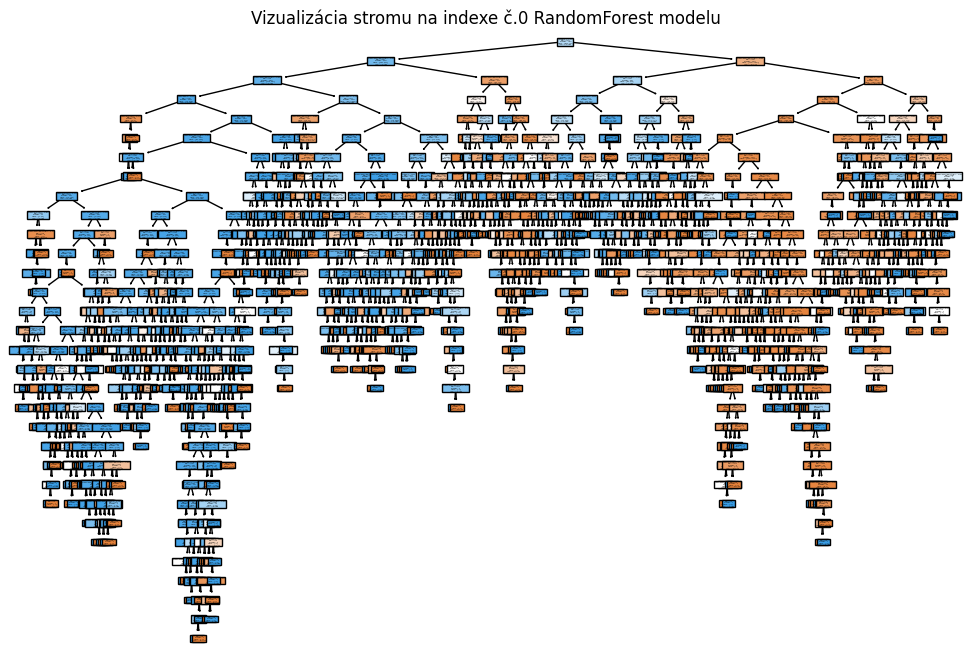

In [26]:
# avg runtime ~35 sec
plt.figure(figsize=(12, 8))
plot_tree(rf_model.estimators_[0], feature_names=X.columns, class_names=X.columns, filled=True)
plt.title("Vizualizácia stromu na indexe č.0 RandomForest modelu")
plt.show()

Následne sme si urobili aj krajšiu vizualizáciu nášho `ID3` klasifikátora, ktorý je jednoduchší ako `RandomForest` a má len niekoľko pravidiel.

In [27]:
def id3_plot_tree(tree, x=0.5, y=1, width=0.2, ax=None, feature_names=None, depth=0):
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('off')

    if 'value' in tree:
        ax.text(x, y, f'mwra: {tree["value"]}', ha='center', va='center', 
                bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=1'))
        return ax

    feature_name = feature_names[tree['feature']]
    text = f'{feature_name} <= {tree["threshold"]:.2f}' if tree['threshold'] else feature_name

    ax.text(x, y, text, ha='center', va='center', bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round,pad=1'))

    left_x = x - width / 2
    right_x = x + width / 2
    child_y = y - 1 / (depth + 1)

    if (tree['left']):
        ax.plot([x, left_x], [y, child_y], 'k-')
        id3_plot_tree(tree['left'], x=left_x, y=child_y, width=width / 2, ax=ax, feature_names=feature_names, depth=depth + 1)
    if (tree['right']):
        ax.plot([x, right_x], [y, child_y], 'k-')
        id3_plot_tree(tree['right'], x=right_x, y=child_y, width=width / 2, ax=ax, feature_names=feature_names, depth=depth + 1)

    return ax

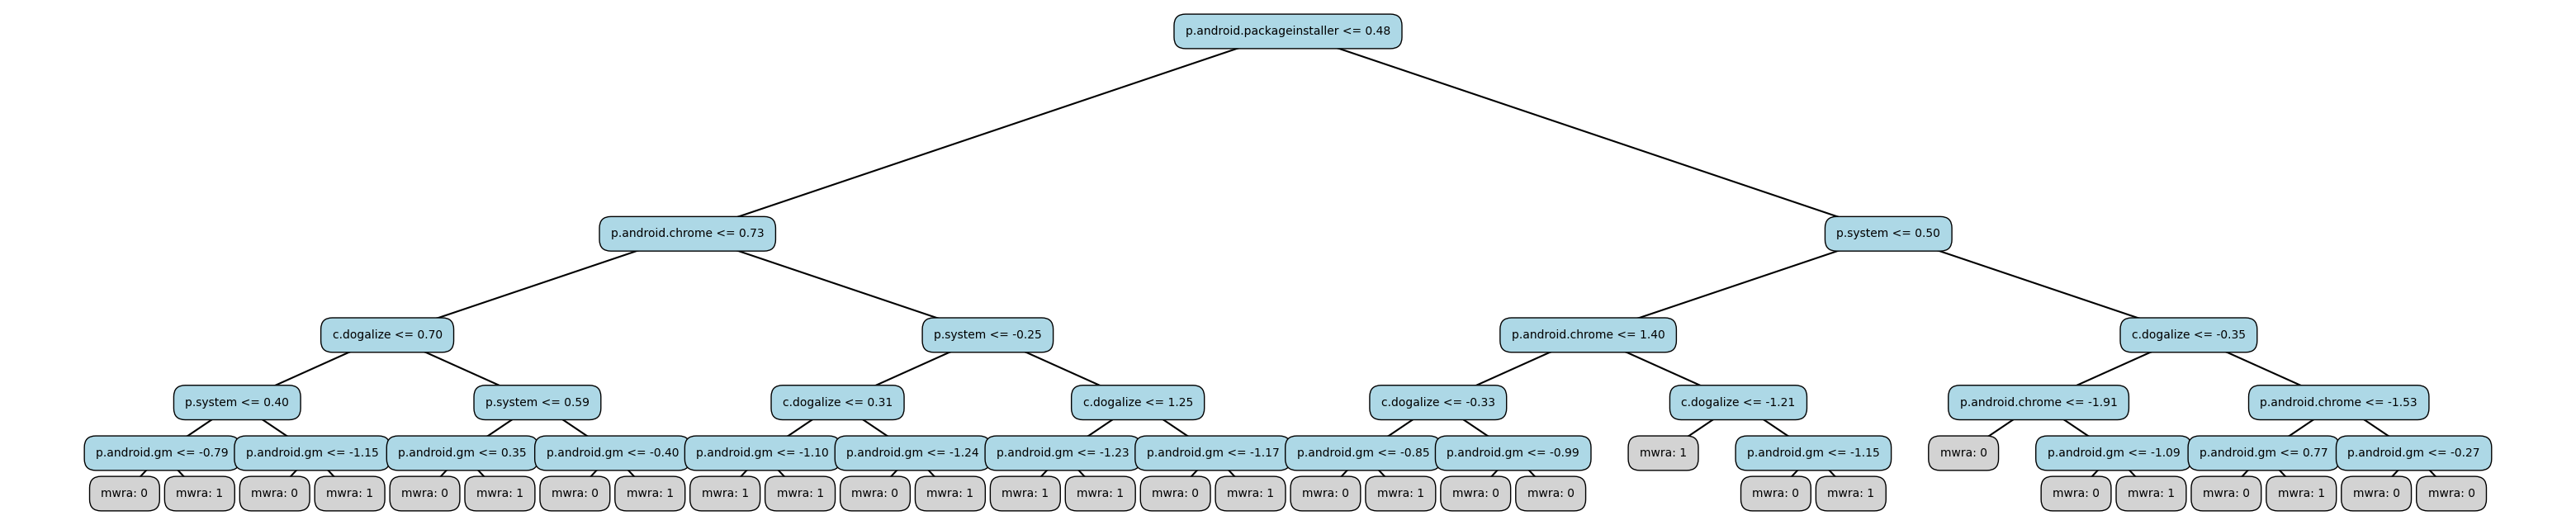

In [28]:
fig, ax = plt.subplots(figsize=(40, 8))
id3_plot_tree(id3_classifier.tree_, feature_names=X.columns, ax=ax)
plt.show()

#### 3.2.E Vyhodnoťte natrénované modely pomocou metrík accuracy, precision a recall

Vyhodnotenie metrík pre všetky modeli bolo spomenuté už vyššie v sekcii `3.2.C`, keď sme porovnávali ich úspešnosť a prítomnosť overfitu resp. underfitu.

### 3.3 Optimalizácia alias hyperparameter tuning

#### 3.3.A Vyskúšajte rôzne nastavenie hyperparametrov (tuning) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).

Keďže `RandomForestClassifier` model mal overfit, tak sme si ho vybrali ako kandidáta na optimalizáciu pomocou hyperparameter tuningu.

In [29]:
# avg runtime
# n_jobs=-1 ->  ~4 min

model_new = RandomForestClassifier(random_state=42, n_jobs=-1)

param_grid_new = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

grid_search_new = GridSearchCV(model_new, param_grid_new, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_new.fit(X_train, y_train)

tuning_model_new = grid_search_new.best_estimator_

print("Best Parameters:", grid_search_new.best_params_)
print("Best Score:", grid_search_new.best_score_)

c:\Marek\Documents\Coding\IAU\iau\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.8574062572998802


In [30]:
print("Tuning Model (RandomForest) Train Score:", tuning_model_new.score(X_train, y_train))
print("Tuning Model (RandomForest) Test  Score:", tuning_model_new.score(X_test, y_test))

Tuning Model (RandomForest) Train Score: 0.8722923810320314
Tuning Model (RandomForest) Test  Score: 0.8408026755852843


Môžeme si všimnúť, že model po optimalizácii nemá overfit, pretože delta medzi úspešnosťou trénovacej a testovacej množiny je `3%`, čo je výrazné zlepšenie oproti pôvodným `11%`. A ani underfit pretože úspešnosť je relatívne vysoká.

Zároveň sme si vyskúšali hyperparameter tuning aj pre `SVC` model, ktorý nemal overfit.

In [31]:
# avg runtime ~
# n_jobs=-1 -> 3 min

model = SVC()

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1, 10]
    # 'C': [10, 100, 1000],
    # 'kernel': ['linear', 'rbf', 'poly'],
    # 'gamma': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

tuning_model = grid_search.best_estimator_

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Score: 0.8585773504040374


In [32]:
print("Tuning Model (SVC) Train Score:", tuning_model.score(X_train, y_train))
print("Tuning Model (SVC) Test  Score:", tuning_model.score(X_test, y_test))

Tuning Model (SVC) Train Score: 0.8599983273396337
Tuning Model (SVC) Test  Score: 0.8441471571906355


Môžeme vidieť, že jeho úspešnosť sa nijako nezmenila s tým, že model nemá underfit ani overfit.

#### 3.3.B Vyskúšajte kombinácie modelov (ensemble) pre zvolený algoritmus tak, aby ste optimalizovali výkonnosť (bez underfitingu).

Ako modely do ensemble sme si zvolili `RandomForestClassifier` a `SVC`, ktoré sme následne skombinovali do jedného modelu pomocou `StackingClassifier`. Ako parametre modelov sme určili tie, ktoré sme získali z hyperparameter tuning.

In [33]:
# avg runtime
# n_jobs=-1 -> 40 sec

base_models = [
    ('svm', SVC(C=10, gamma=0.1, kernel='rbf', probability=True)),
    ('tree', RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=200, n_jobs=-1))
]

stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), n_jobs=-1)
stacking_model.fit(X_train, y_train)

ensemble_model = stacking_model

In [34]:
print("Enseble Model Train Score:", ensemble_model.score(X_train, y_train))
print("Enseble Model Test  Score:", ensemble_model.score(X_test, y_test))

Enseble Model Train Score: 0.8711215187756126
Enseble Model Test  Score: 0.8414715719063545


Môžeme vidieť že úspešnosť modelu je `84%` na testovacej množine, čo značí o tom, že model nemá underfit. Bohužiaľ sa nám stále nedarí optimalizovať model tak, aby mal vyššiu úspešnosť.

#### 3.3.C Využite krížovú validáciu (cross validation) na trénovacej množine.

Najskôr sme si urobili krížovú validáciu pre `RandomForestClassifier` model, ktorý sme optimalizovali pomocou parametrov ktoré nám vrátily `GridSearchCV` vyššie v dokumente.

In [35]:
# avg runtime ~50 sec
# n_jobs=-1 -> 6 sec

model = RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=2, n_estimators=200, n_jobs=-1)

cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.84448161 0.86120401 0.85869565 0.85117057 0.87040134 0.86538462
 0.84615385 0.86861925 0.85690377 0.85439331]
Mean CV Score: 0.8577407956787619


Následne sme si urobili krížovú validáciu pre `SVC` model, ktorý sme tiež pomocou `GridSearchCV` optimalizovali.

In [36]:
# avg runtime ~25 sec
# n_jobs=-1 -> 4 sec
cv_scores = cross_val_score(tuning_model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.840301   0.86036789 0.85869565 0.85284281 0.86956522 0.86371237
 0.85200669 0.86694561 0.85690377 0.86025105]
Mean CV Score: 0.8581592057206029


Ako poslednú sme si vyskúšali krížovú validáciu pre `StackingClassifier` model, ktorý sme vytvorili z kombinácie `RandomForestClassifier` a `SVC` modelov.

In [37]:
# avg runtime ~7,5 min
# n_jobs=-1 -> 1,5 min
cv_scores = cross_val_score(ensemble_model, X_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())

Cross-Validation Scores: [0.84698997 0.86120401 0.85785953 0.85200669 0.86622074 0.86622074
 0.84782609 0.87029289 0.85857741 0.85439331]
Mean CV Score: 0.8581591357523685


Môžeme si všimnúť že všetky 3 druhy krížovej validácie majú rovnakú úspešnosť.

#### 3.3.D Dokážte že Váš nastavený najlepší model je bez overfitingu.

Podľa predchádzajúcich metrík sme zistili, že náš doposial najlepší model je optimalizovaný `SVC` model pomocou hyperparameter tuningu.

In [38]:
print("Tuning Model Train Score:", tuning_model.score(X_train, y_train))
print("Tuning Model Test  Score:", tuning_model.score(X_test, y_test))

Tuning Model Train Score: 0.8599983273396337
Tuning Model Test  Score: 0.8441471571906355


Podľa metriky `score` (`accuracy`) môžeme vidieť, že model nemá overfit, pretože delta medzi trénovacou a testovacou množinou je `~1%` a zároveň ani underfit pretože má relatívne vysokú úspešnosť.

### 3.4 Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu

Aby sme vyhodnotili, či náš proces predspracovania a modelovania bol správny, urobili sme bruteforce medzi veľa kombináciami objektov z predprocesing pipeline.

Urobili sme viacej iterácií bruteforce, kde po každej iterácii sme ju zanalyzovali a podľa nej sme navrhli ako má vyzerať ďalšia iterácia.

Na začiatku sme si načítali "raw" data a urobili sme si prípavu na robenie s pipelinami.

In [39]:
df_connections = pd.read_csv('112/connections.csv', delimiter=',')
df_processes   = pd.read_csv('112/processes.csv', delimiter=',')

merged_data = df_connections.merge(df_processes, on=['imei', 'ts'], how='inner')
merged_data['ts'] = pd.to_numeric(pd.to_datetime(merged_data['ts'], errors='coerce'))
merged_data = merged_data.drop_duplicates()
merged_data = merged_data.drop(columns=['mwra_y'])
merged_data = merged_data.rename(columns={"mwra_x": "mwra"})

X_raw = merged_data.drop(columns='mwra')
y_raw = merged_data['mwra']

X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)

In [40]:
# co-engineered with ChatGPT - from phase 2
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=1.5, outlier_fraction=0.05):
        self.threshold = threshold
        self.outlier_fraction = outlier_fraction
        self.imputer = SimpleImputer(strategy='median')

    def fit(self, X, y=None):
        self.iqr = np.percentile(X, 75, axis=0) - np.percentile(X, 25, axis=0)
        self.lower_bound = np.percentile(X, 25, axis=0) - self.threshold * self.iqr
        self.upper_bound = np.percentile(X, 75, axis=0) + self.threshold * self.iqr
        return self

    def transform(self, X):
        outliers_mask = np.any((X < self.lower_bound) | (X > self.upper_bound), axis=1)
        num_outliers = np.sum(outliers_mask)
        total_samples = X.shape[0]
        outlier_fraction = num_outliers / total_samples
        
        if outlier_fraction < self.outlier_fraction:
            return X[~outliers_mask]
        else:
            X_imputed = X.copy()
            X_imputed[outliers_mask] = np.nan
            return self.imputer.fit_transform(X_imputed)

Takto vyzeral náš pipeline na konci 2 fázy:
```py
preprocessor_pipeline = 
Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('outlier_handler', OutlierHandler(threshold=1.5, outlier_fraction=0.05)),
        ('scaler', MinMaxScaler()),
        ('power_transformer', PowerTransformer(method='yeo-johnson')),
        ('feature_selection', SelectKBest(mutual_info_regression, k=5))],
    verbose=True
)
```

Typy objektov, ktorých kombinácie sme skúšali v našom bruteforce:

In [41]:
# we commented out the ones with worst scores so the bruteforce does not run so long

imputers = [
    SimpleImputer(strategy='mean'),
    SimpleImputer(strategy='median'),
    # KNNImputer(n_neighbors=5)
]

outlier_handlers = [
    OutlierHandler(threshold=1.5, outlier_fraction=0.05),
    OutlierHandler(threshold=2.0, outlier_fraction=0.1)
]

scalers = [
    MinMaxScaler(),
    # StandardScaler(),
    RobustScaler()
]

transformers = [
    PowerTransformer(method='yeo-johnson'),
    QuantileTransformer(output_distribution='normal'),
    # QuantileTransformer(output_distribution='uniform')
]

feature_selections = [
    SelectKBest(mutual_info_regression, k=5),
    SelectKBest(f_regression, k=5),
    # SelectKBest(f_classif, k=5),
    # SelectKBest(chi2, k=5),
    VarianceThreshold(threshold=0.1)
]

In [42]:
classifiers = [
    svc_model,
    tuning_model,
]

In [43]:
# avg runtime ~9,5 min
# 45 min last run
evaluated_models = []
good_preprocessor_count = 0
good_classifier_count = 0

def bruteforce(imputers, outlier_handlers, scalers, transformers, feature_selections, classifiers):
    global evaluated_models, good_preprocessor_count, good_classifier_count
    evaluated_models = []
    good_preprocessor_count = 0
    good_classifier_count = 0

    preprocessors = []
    for imputer in imputers:
        for outlier_handler in outlier_handlers:
            for scaler in scalers:
                for transformer in transformers:
                    for feature_selection in feature_selections:
                        preprocessor = Pipeline(steps=[
                            ('imputer', imputer),
                            ('outlier_handler', outlier_handler),
                            ('scaler', scaler),
                            ('transformer', transformer),
                            ('feature_selection', feature_selection)
                            ],
                            verbose=False
                        )
                        preprocessors.append(preprocessor)

    model_index = 0
    best_train_score = 0
    best_test_score = 0
    for preprocessor in preprocessors:
        print(f"preprocessor {preprocessors.index(preprocessor)+1}/{len(preprocessors)}")
        try:
            preprocessor.fit(X_raw_train, y_raw_train)

            X_train_preprocessed = preprocessor.transform(X_raw_train)
            X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_raw_train.columns[preprocessor.named_steps['feature_selection'].get_support()], index=X_raw_train.index)

            X_test_preprocessed = preprocessor.transform(X_raw_test)
            X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=X_raw_test.columns[preprocessor.named_steps['feature_selection'].get_support()], index=X_raw_test.index)

            for classifier in classifiers:
                print(f"PREPROCESSOR GOOD: {preprocessor}")
                good_preprocessor_count += 1
                
                try:
                    classifier.fit(X_train_preprocessed, y_raw_train)

                    train_score = classifier.score(X_train_preprocessed, y_train)
                    test_score = classifier.score(X_test_preprocessed, y_test)

                    if train_score > best_train_score or test_score > best_test_score:
                        model = Pipeline([
                            ('preprocessor', preprocessor),
                            ('classifier', classifier),
                            ],
                            verbose=False
                        )
                        
                        delta = train_score - test_score
                        y_pred = classifier.predict(X_test_preprocessed)
                        accuracy = accuracy_score(y_raw_test, y_pred)
                        precision = precision_score(y_raw_test, y_pred, average='weighted')
                        recall = recall_score(y_raw_test, y_pred, average='weighted')
                        
                        evaluated_models.append({
                            "train": train_score,
                            "test": test_score,
                            "delta": delta,
                            "index": model_index,
                            "model": model,
                            "accuracy": accuracy,
                            "precision": precision,
                            "recall": recall,
                        })

                        if train_score > best_train_score:
                            best_train_score = train_score
                        if test_score > best_test_score:
                            best_test_score = test_score

                    model_index += 1
                    
                    print(f"CLASSIFIER GOOD: {(classifier)}")
                    good_classifier_count += 1

                except Exception as ee:
                    print(f"CLASSIFIER BAD : {classifier}\n{ee}")
                    print("--------------------------------------------------------------------------------------------------")
                    model_index += 1
                
                print("--------------------------------------------------------------------------------------------------")

        except Exception as e:
            print(f"PREPROCESSOR BAD : {preprocessor}\n{e}")
            model_index += 2
            print("--------------------------------------------------------------------------------------------------")

In [44]:
bruteforce(imputers, outlier_handlers, scalers, transformers, feature_selections, classifiers)

preprocessor 1/48
PREPROCESSOR GOOD: Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler', OutlierHandler()),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_regression at 0x000001E6C1010CC0>))])
CLASSIFIER GOOD: SVC(random_state=42)
--------------------------------------------------------------------------------------------------
PREPROCESSOR GOOD: Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler', OutlierHandler()),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_regression at 0x000001E6C1010CC0>))])
CLASSIFIER GOOD: SVC(C=10, gamma=0.1)
-------------------------------------------------------------

In [45]:
print(f"good_preprocessor_count {good_preprocessor_count}")
print(f"good_classifier_count   {good_classifier_count}")
print(f"len(evaluated_models)   {len(evaluated_models)}")

good_preprocessor_count 96
good_classifier_count   96
len(evaluated_models)   6


In [46]:
def print_iteration_info_type_1():
    global evaluated_models
    evaluated_models = sorted(evaluated_models, key=lambda x: x['test'], reverse=True)
    for i in range(len(evaluated_models)):
        model = evaluated_models[i]
        print('train   test    delta  accuracy  precision  recall')
        print(f"{model['train']*100:.2f}%  ", end='')
        print(f"{model['test']*100:.2f}%  ", end='')
        print(f"{model['delta']*100:.2f}%  ", end='')
        print(f"{model['accuracy']*100:.2f}%    ", end='')
        print(f"{model['precision']*100:.2f}%     ", end='')
        print(f"{model['recall']*100:.2f}%  ")
        print(f"preprocessor:{model['model'].steps[0]}")
        print(f"classifier:{model['model'].steps[1]}")
        print('-------------------------------------------------------------------------------------------------------------------')

In [47]:
def print_iteration_info_type_2():
    global evaluated_models
    evaluated_models = sorted(evaluated_models, key=lambda x: x['test'], reverse=True)
    for step_i in range(len(evaluated_models[0]['model'].steps[0][1].steps)):
        for i in range(len(evaluated_models)):
            model = evaluated_models[i]
            print('train   test    delta  accuracy  precision  recall')
            print(f"{model['train']*100:.2f}%  ", end='')
            print(f"{model['test']*100:.2f}%  ", end='')
            print(f"{model['delta']*100:.2f}%  ", end='')
            print(f"{model['accuracy']*100:.2f}%    ", end='')
            print(f"{model['precision']*100:.2f}%     ", end='')
            print(f"{model['recall']*100:.2f}%  ")
            print(model['model'].steps[0][1].steps[step_i])
            print()
        print('--------------------------------------------------------------------')

In [48]:
def print_iteration_info_type_3():
    global evaluated_models
    evaluated_models = sorted(evaluated_models, key=lambda x: x['delta'], reverse=False)
    for step_i in range(len(evaluated_models[0]['model'].steps[0][1].steps)):
        for i in range(len(evaluated_models)):
            model = evaluated_models[i]
            print('train   test    delta  accuracy  precision  recall')
            print(f"{model['train']*100:.2f}%  ", end='')
            print(f"{model['test']*100:.2f}%  ", end='')
            print(f"{model['delta']*100:.2f}%  ", end='')
            print(f"{model['accuracy']*100:.2f}%    ", end='')
            print(f"{model['precision']*100:.2f}%     ", end='')
            print(f"{model['recall']*100:.2f}%  ")
            print(model['model'].steps[0][1].steps[step_i])
            print()
        print('--------------------------------------------------------------------')

In [49]:
print_iteration_info_type_1()

train   test    delta  accuracy  precision  recall
91.85%  90.20%  1.65%  90.20%    90.19%     90.20%  
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection', VarianceThreshold(threshold=0.1))]))
classifier:('classifier', SVC(random_state=42))
-------------------------------------------------------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
98.53%  89.77%  8.76%  89.77%    89.76%     89.77%  
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature

In [50]:
print_iteration_info_type_2()

train   test    delta  accuracy  precision  recall
91.85%  90.20%  1.65%  90.20%    90.19%     90.20%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
98.53%  89.77%  8.76%  89.77%    89.76%     89.77%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
89.08%  87.59%  1.49%  87.59%    87.80%     87.59%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
94.89%  87.16%  7.73%  87.16%    87.39%     87.16%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
86.18%  84.45%  1.73%  84.45%    84.47%     84.45%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
86.13%  84.31%  1.82%  84.31%    84.35%     84.31%  
('imputer', SimpleImputer())

--------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
91.85%  90.20%  1.65%  90.20%    90.19%     90.20%  
('outlier_handler', Out

In [51]:
print_iteration_info_type_3()

train   test    delta  accuracy  precision  recall
89.08%  87.59%  1.49%  87.59%    87.80%     87.59%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
91.85%  90.20%  1.65%  90.20%    90.19%     90.20%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
86.18%  84.45%  1.73%  84.45%    84.47%     84.45%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
86.13%  84.31%  1.82%  84.31%    84.35%     84.31%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
94.89%  87.16%  7.73%  87.16%    87.39%     87.16%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
98.53%  89.77%  8.76%  89.77%    89.76%     89.77%  
('imputer', SimpleImputer())

--------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
89.08%  87.59%  1.49%  87.59%    87.80%     87.59%  
('outlier_handler', Out

Optimal model from iteration 1:

```py
train: 89.03%  test:87.73%  delta:1.30%  
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection', VarianceThreshold(threshold=0.1))]))
classifier:('classifier', SVC(kernel='linear', random_state=42))
```

____________________________________________________________________________________
**Iteration 2**

In [52]:
imputers2 = [
    SimpleImputer(),
]

outlier_handlers2 = [
    OutlierHandler(threshold=2.0, outlier_fraction=0.1)
]

scalers2 = [
    MinMaxScaler(),
    RobustScaler()
]

transformers2 = [
    PowerTransformer(method='yeo-johnson'),
]

feature_selections2 = [
    SelectKBest(mutual_info_regression, k=5),
    SelectKBest(f_regression, k=5),
    VarianceThreshold(threshold=0.1)
]

In [53]:
classifiers2 = [
    svc_model,
    tuning_model,
]

In [54]:
bruteforce(imputers2, outlier_handlers2, scalers2, transformers2, feature_selections2, classifiers2)

preprocessor 1/6
PREPROCESSOR GOOD: Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_regression at 0x000001E6C1010CC0>))])
CLASSIFIER GOOD: SVC(random_state=42)
--------------------------------------------------------------------------------------------------
PREPROCESSOR GOOD: Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_regression at 0x000001E6C1010CC0>)

In [55]:
print_iteration_info_type_1()

train   test    delta  accuracy  precision  recall
91.85%  90.20%  1.65%  90.20%    90.19%     90.20%  
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection', VarianceThreshold(threshold=0.1))]))
classifier:('classifier', SVC(random_state=42))
-------------------------------------------------------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
98.53%  89.77%  8.76%  89.77%    89.76%     89.77%  
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature

In [56]:
print_iteration_info_type_2()

train   test    delta  accuracy  precision  recall
91.85%  90.20%  1.65%  90.20%    90.19%     90.20%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
98.53%  89.77%  8.76%  89.77%    89.76%     89.77%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
88.99%  87.53%  1.46%  87.53%    87.45%     87.53%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
89.04%  87.46%  1.59%  87.46%    87.39%     87.46%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
87.98%  86.25%  1.73%  86.25%    86.17%     86.25%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
87.95%  86.19%  1.76%  86.19%    86.10%     86.19%  
('imputer', SimpleImputer())

--------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
91.85%  90.20%  1.65%  90.20%    90.19%     90.20%  
('outlier_handler', Out

In [57]:
print_iteration_info_type_3()

train   test    delta  accuracy  precision  recall
88.99%  87.53%  1.46%  87.53%    87.45%     87.53%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
89.04%  87.46%  1.59%  87.46%    87.39%     87.46%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
91.85%  90.20%  1.65%  90.20%    90.19%     90.20%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
87.98%  86.25%  1.73%  86.25%    86.17%     86.25%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
87.95%  86.19%  1.76%  86.19%    86.10%     86.19%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
98.53%  89.77%  8.76%  89.77%    89.76%     89.77%  
('imputer', SimpleImputer())

--------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
88.99%  87.53%  1.46%  87.53%    87.45%     87.53%  
('outlier_handler', Out

Optimal model from iteration 2:

train   test    delta

91.85%  90.20%  1.65%

```py
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection', VarianceThreshold(threshold=0.1))]))
classifier:('classifier', SVC(random_state=42))
```

In [58]:
imputers3 = [
    SimpleImputer(),
]

outlier_handlers3 = [
    OutlierHandler(threshold=2.0, outlier_fraction=0.1)
]

scalers3 = [
    MinMaxScaler(),
    RobustScaler()
]

transformers3 = [
    PowerTransformer(method='yeo-johnson'),
]

feature_selections3 = [
    SelectKBest(mutual_info_regression, k=7),
    SelectKBest(mutual_info_regression, k=9),
    SelectKBest(mutual_info_regression, k=11),
    SelectKBest(mutual_info_regression, k=13),
]

In [59]:
classifiers3 = [
    tuning_model,
]

In [60]:
bruteforce(imputers3, outlier_handlers3, scalers3, transformers3, feature_selections3, classifiers3)

preprocessor 1/8
PREPROCESSOR GOOD: Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=7,
                             score_func=<function mutual_info_regression at 0x000001E6C1010CC0>))])
CLASSIFIER GOOD: SVC(C=10, gamma=0.1)
--------------------------------------------------------------------------------------------------
preprocessor 2/8
PREPROCESSOR GOOD: Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=9,
                             score_func=<function mutual_info_regression at 0x0

In [61]:
print_iteration_info_type_1()

train   test    delta  accuracy  precision  recall
91.95%  90.30%  1.65%  90.30%    90.31%     90.30%  
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=11,
                             score_func=<function mutual_info_regression at 0x000001E6C1010CC0>))]))
classifier:('classifier', SVC(C=10, gamma=0.1))
-------------------------------------------------------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
92.97%  90.07%  2.90%  90.07%    90.08%     90.07%  
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
       

In [62]:
print_iteration_info_type_2()

train   test    delta  accuracy  precision  recall
91.95%  90.30%  1.65%  90.30%    90.31%     90.30%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
92.97%  90.07%  2.90%  90.07%    90.08%     90.07%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
91.15%  89.83%  1.32%  89.83%    89.83%     89.83%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
93.28%  89.40%  3.89%  89.40%    89.38%     89.40%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
89.54%  87.59%  1.95%  87.59%    87.55%     87.59%  
('imputer', SimpleImputer())

--------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
91.95%  90.30%  1.65%  90.30%    90.31%     90.30%  
('outlier_handler', OutlierHandler(outlier_fraction=0.1, threshold=2.0))

train   test    delta  accuracy  precision  recall
92.97%  90.07%  2.90%  90.07%   

In [63]:
print_iteration_info_type_3()

train   test    delta  accuracy  precision  recall
91.15%  89.83%  1.32%  89.83%    89.83%     89.83%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
91.95%  90.30%  1.65%  90.30%    90.31%     90.30%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
89.54%  87.59%  1.95%  87.59%    87.55%     87.59%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
92.97%  90.07%  2.90%  90.07%    90.08%     90.07%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
93.28%  89.40%  3.89%  89.40%    89.38%     89.40%  
('imputer', SimpleImputer())

--------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
91.15%  89.83%  1.32%  89.83%    89.83%     89.83%  
('outlier_handler', OutlierHandler(outlier_fraction=0.1, threshold=2.0))

train   test    delta  accuracy  precision  recall
91.95%  90.30%  1.65%  90.30%   

Optimal model from iteration 3:

train   test    delta

91.85%  90.10%  1.75%

```py
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=11,
                             score_func=<function mutual_info_regression at 0x0000015DD0FB5800>))]))
classifier:('classifier', SVC(C=10, gamma=0.1))
```

In [64]:
imputers4 = [
    SimpleImputer(),
]

outlier_handlers4 = [
    OutlierHandler(threshold=2.5, outlier_fraction=0.1),
    OutlierHandler(threshold=2.5, outlier_fraction=0.05),
    OutlierHandler(threshold=3.0, outlier_fraction=0.1),
    OutlierHandler(threshold=3.0, outlier_fraction=0.05),
]

scalers4 = [
    MinMaxScaler(),
    RobustScaler()
]

transformers4 = [
    PowerTransformer(method='yeo-johnson'),
]

feature_selections4 = [
    SelectKBest(mutual_info_regression, k=11),
]

In [65]:
classifiers4 = [
    tuning_model,
]

In [66]:
bruteforce(imputers4, outlier_handlers4, scalers4, transformers4, feature_selections4, classifiers4)

preprocessor 1/8
PREPROCESSOR BAD : Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.5)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=11,
                             score_func=<function mutual_info_regression at 0x000001E6C1010CC0>))])
Found input variables with inconsistent numbers of samples: [10901, 11957]
--------------------------------------------------------------------------------------------------
preprocessor 2/8
PREPROCESSOR BAD : Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.5)),
                ('scaler', RobustScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=11,
                             score_func=

In [67]:
print_iteration_info_type_1()

train   test    delta  accuracy  precision  recall
92.33%  90.67%  1.66%  90.67%    90.67%     90.67%  
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler', OutlierHandler(threshold=3.0)),
                ('scaler', RobustScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=11,
                             score_func=<function mutual_info_regression at 0x000001E6C1010CC0>))]))
classifier:('classifier', SVC(C=10, gamma=0.1))
-------------------------------------------------------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
92.26%  90.54%  1.73%  90.54%    90.54%     90.54%  
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler', OutlierHandler(threshold=2.5)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
    

In [68]:
print_iteration_info_type_2()

train   test    delta  accuracy  precision  recall
92.33%  90.67%  1.66%  90.67%    90.67%     90.67%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
92.26%  90.54%  1.73%  90.54%    90.54%     90.54%  
('imputer', SimpleImputer())

--------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
92.33%  90.67%  1.66%  90.67%    90.67%     90.67%  
('outlier_handler', OutlierHandler(threshold=3.0))

train   test    delta  accuracy  precision  recall
92.26%  90.54%  1.73%  90.54%    90.54%     90.54%  
('outlier_handler', OutlierHandler(threshold=2.5))

--------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
92.33%  90.67%  1.66%  90.67%    90.67%     90.67%  
('scaler', RobustScaler())

train   test    delta  accuracy  precision  recall
92.26%  90.54%  1.73%  90.54%    90.54%     90.54%  
('scaler', MinMaxScaler())

------------------

In [69]:
print_iteration_info_type_3()

train   test    delta  accuracy  precision  recall
92.33%  90.67%  1.66%  90.67%    90.67%     90.67%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
92.26%  90.54%  1.73%  90.54%    90.54%     90.54%  
('imputer', SimpleImputer())

--------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
92.33%  90.67%  1.66%  90.67%    90.67%     90.67%  
('outlier_handler', OutlierHandler(threshold=3.0))

train   test    delta  accuracy  precision  recall
92.26%  90.54%  1.73%  90.54%    90.54%     90.54%  
('outlier_handler', OutlierHandler(threshold=2.5))

--------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
92.33%  90.67%  1.66%  90.67%    90.67%     90.67%  
('scaler', RobustScaler())

train   test    delta  accuracy  precision  recall
92.26%  90.54%  1.73%  90.54%    90.54%     90.54%  
('scaler', MinMaxScaler())

------------------

Optimal model from iteration 4:

train   test    delta

92.33%  90.67%  1.66%

```py
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler', OutlierHandler(threshold=3.0)),
                ('scaler', RobustScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=11,
                             score_func=<function mutual_info_regression at 0x0000015DD0FB5800>))]))
classifier:('classifier', SVC(C=10, gamma=0.1))
```

____________________________________________________________________________________
**Iteration 5**

In [70]:
# we commented out the ones with worst scores so the broteforce doesnt run so long

imputers5 = [
    SimpleImputer(strategy='mean'),
    # SimpleImputer(strategy='median'),
    # KNNImputer(n_neighbors=5)
]

outlier_handlers5 = [
    # OutlierHandler(threshold=1.5, outlier_fraction=0.05),
    OutlierHandler(threshold=2.0, outlier_fraction=0.1),
    OutlierHandler(threshold=3.0, outlier_fraction=0.05)
]

scalers5 = [
    MinMaxScaler(),
    # StandardScaler(),
    # RobustScaler()
]

transformers5 = [
    PowerTransformer(method='yeo-johnson'),
    # QuantileTransformer(output_distribution='normal'),
    # QuantileTransformer(output_distribution='uniform')
]

feature_selections5 = [
    SelectKBest(mutual_info_regression, k=5),
    SelectKBest(f_regression, k=5),
    SelectKBest(mutual_info_regression, k=11),
    SelectKBest(f_regression, k=11),
    # SelectKBest(f_classif, k=5),
    # SelectKBest(chi2, k=5),
    VarianceThreshold(threshold=0.1)
]

In [71]:
classifiers5 = [
    # DecisionTreeClassifier(random_state=42),
    # RandomForestClassifier(random_state=42),
    # svc_model,
    # tuning_model,
    tuning_model_new,
]

In [72]:
bruteforce(imputers5, outlier_handlers5, scalers5, transformers5, feature_selections5, classifiers5)

preprocessor 1/10
PREPROCESSOR GOOD: Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=5,
                             score_func=<function mutual_info_regression at 0x000001E6C1010CC0>))])
CLASSIFIER GOOD: RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42)
--------------------------------------------------------------------------------------------------
preprocessor 2/10
PREPROCESSOR GOOD: Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler',
                 OutlierHandler(outlier_fraction=0.1, threshold=2.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
      

In [73]:
print(f"good_preprocessor_count {good_preprocessor_count}")
print(f"good_classifier_count   {good_classifier_count}")
print(f"len(evaluated_models)   {len(evaluated_models)}")

good_preprocessor_count 10
good_classifier_count   10
len(evaluated_models)   7


In [74]:
print_iteration_info_type_1()

train   test    delta  accuracy  precision  recall
92.31%  89.83%  2.48%  89.83%    89.79%     89.83%  
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler', OutlierHandler(threshold=3.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection', VarianceThreshold(threshold=0.1))]))
classifier:('classifier', RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42))
-------------------------------------------------------------------------------------------------------------------
train   test    delta  accuracy  precision  recall
92.06%  89.53%  2.53%  89.53%    89.49%     89.53%  
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler', OutlierHandler(threshold=3.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer())

In [75]:
print_iteration_info_type_2()

train   test    delta  accuracy  precision  recall
92.31%  89.83%  2.48%  89.83%    89.79%     89.83%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
92.06%  89.53%  2.53%  89.53%    89.49%     89.53%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
92.12%  89.50%  2.62%  89.50%    89.45%     89.50%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
91.80%  89.40%  2.40%  89.40%    89.35%     89.40%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
91.64%  89.36%  2.27%  89.36%    89.33%     89.36%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
90.37%  87.39%  2.98%  87.39%    87.32%     87.39%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
90.11%  86.45%  3.65%  86.45%    86.37%     86.45%  
('imputer', SimpleImputer())

--------------------------------------------------------------

In [76]:
print_iteration_info_type_3()

train   test    delta  accuracy  precision  recall
91.64%  89.36%  2.27%  89.36%    89.33%     89.36%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
91.80%  89.40%  2.40%  89.40%    89.35%     89.40%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
92.31%  89.83%  2.48%  89.83%    89.79%     89.83%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
92.06%  89.53%  2.53%  89.53%    89.49%     89.53%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
92.12%  89.50%  2.62%  89.50%    89.45%     89.50%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
90.37%  87.39%  2.98%  87.39%    87.32%     87.39%  
('imputer', SimpleImputer())

train   test    delta  accuracy  precision  recall
90.11%  86.45%  3.65%  86.45%    86.37%     86.45%  
('imputer', SimpleImputer())

--------------------------------------------------------------

Optimal model from iteration 5:

train   test    delta

92.31%  89.83%  2.48%

```py
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler', OutlierHandler(threshold=3.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection', VarianceThreshold(threshold=0.1))]))
classifier:('classifier', RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       n_jobs=-1, random_state=42))
```

#### 3.4.A Stratégie riešenia chýbajúcich hodnôt a outlierov

Chýbajúce hodnoty sme vždy dokázali nahradiť použitím `SimpleImputer`, pričom stačilo použiť stratégiu mean (priemer).
Najlepšie riešenie outlierov bolo, že sme zvýšili prahovú hodnotu (threshold). Ak dáta mali pár outlierov, tak model lepšie generalizoval.

#### 3.4.B Dátová transformácia (scaling, transformer, …)

Pri použití `RobustScaler` a `MinMaxScaler` boli výsledky modelov na podobnej úrovni, ale najlepšie modely využívali `MinMaxScaler`. `StandardScaler` takmer žiadny model nepoužil.


#### 3.4.C Výber atribútov, výber algoritmov, hyperparameter tuning, ensemble learning

Náš pôvodný výber príznakov (feature selection) bol k = 5, ale keď sme ho zvýšili na k = 11, zlepšila sa úspešnosť modelu. Pri väčších hodnotách `k` už ku zlepšeniu nedošlo.

#### 3.4.D Ktorý model je Váš najlepší model pre nasadenie (deployment)?

Z bruteforce sme zistili, že nasledujúci pipeline a model resp. klasifikátor je najlepší pre nasadenie do produkcie (deployment):

| Train   | Test   | Delta   | Accuracy | Precision | Recall |
|---------|--------|---------|----------|-----------|--------|
| 92.30%  | 90.70% | 1.60%   | 90.70%   | 90.70%    | 90.70% |


```py
preprocessor:('preprocessor', Pipeline(steps=[('imputer', SimpleImputer()),
                ('outlier_handler', OutlierHandler(threshold=3.0)),
                ('scaler', MinMaxScaler()), ('transformer', PowerTransformer()),
                ('feature_selection',
                 SelectKBest(k=11,
                             score_func=<function mutual_info_regression at 0x000001B52CA73100>))]))
classifier:('classifier', SVC(C=10, gamma=0.1))
```

#### 3.4.E Aký je data pipeline pre jeho vybudovanie na základe Vášho datasetu v produkcii?

Okrem modelu sme vyššie v sekcii `3.4.D` už spomenuli aj pipeline, ktorý sme použili na vytvorenie nášho najlepšieho modelu. Tento pipeline by sme mohli použiť aj v produkcii, pretože je najlepší zo všetkých, ktoré sme skúšali v bruteforce.

### Záver

Naše lepšie modeli v sekciách `3.1` až `3.3` boli relatívne dobré, pretože väčšinou nemali ani underfit ani overfit a boli stabilné, čo sme zistili z metrík accuracy, precision a recall. Avšak nemali takú vysokú úspešnosť ako sme si nazačiatku predstavovali. Neboli sme vlastne spokojný s úspešnosťou modelov, čoho príčinou bolo asi nie optimálne predspracovanie v druhej fáze. Preto sme sa rozhodli, že pomocou nejakej inteligentnej kombinácie bruteforcu, analýzy a greedy algoritmov zostrojíme najlepší pipeline a zároveň klasifikačný model, ktorý bude mať najlepšiu úspešnosť a nebude mať ani underfit ani overfit, čo sa nám vlastne podarilo.

Z pôvodných modelov, ktoré mali úspešnosť `~83%` sa nám podarilo vytvoriť model, ktorý má úspešnosť `~91%`, čo je veľký rozdiel a zlepšenie.

## Zdroje

Prednášky a cvičenia z predmetu IAU.

[IAU Github repozitár](https://github.com/FIIT-IAU/IAU-course)

[Scipy dokumentácia](https://docs.scipy.org/doc/scipy/reference/index.html)

[Numpy dokumentácia](https://numpy.org/doc/)

[Pandas dokumentácia](https://pandas.pydata.org/docs/)

[Typical Analysis Procedure](https://work.thaslwanter.at/Stats/html/statsAnalysis.html)


[Scikit-learn dokumentácia](https://scikit-learn.org/1.5/api/index.html)

[Feature importance](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

[Scaling](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/)

[Transformations](https://machinelearningmastery.com/power-transforms-with-scikit-learn/)